<a href="https://colab.research.google.com/github/ritwiks9635/Face-image-Detection/blob/main/Fine_Tune_Tech_Support_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **😐Facial 🤣Features Detection Using YOLO**

In [ ]:
!pip install --upgrade keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 50.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import matplotlib.pyplot as plt

In [ ]:
train_dir = "/content/Facial Feature Extraction Dataset/train"
test_dir = "/content/Facial Feature Extraction Dataset/test"
val_dir = "/content/Facial Feature Extraction Dataset/valid"
print(f"Total train data is {len(os.listdir(train_dir + '/images'))}\n total test data is {len(os.listdir(test_dir + '/images'))}\n Total validation data is {len(os.listdir(val_dir + '/images'))}")

Total train data is 457
 total test data is 66
 Total validation data is 126


In [ ]:
print(os.listdir(train_dir + "/labels")[0])
print(os.listdir(train_dir + "/images")[10])

Alisha-Nesvat-2018-12-20-color-portrait-ponytail-choker-collar_jpeg.rf.0f18a01c280eb8eef373055f4fa601c6.txt
_-74-_jpeg.rf.402e888b73b2008bcd4c637ff0431e62.jpg


In [ ]:
batch_size = 8
learning_rate = 0.005
global_clipnorm = 10.0
width = height = 640

In [ ]:
class_names = ['eye', 'eyebrow', 'lip', 'mustache-beard', 'nose']
class_mapping = dict(zip(range(len(class_names)), class_names))
class_mapping

{0: 'eye', 1: 'eyebrow', 2: 'lip', 3: 'mustache-beard', 4: 'nose'}

In [ ]:
train_images = sorted([
    os.path.join(train_dir + "/images", img)
    for img in os.listdir(train_dir + "/images")
    ])

train_labels = sorted([
    os.path.join(train_dir + "/labels", lab)
    for lab in os.listdir(train_dir + "/labels")
    ])

test_images = sorted([
    os.path.join(test_dir + "/images", img)
    for img in os.listdir(test_dir + "/images")
    ])

test_labels = sorted([
    os.path.join(test_dir + "/labels", lab)
    for lab in os.listdir(test_dir + "/labels")
    ])


val_images = sorted([
    os.path.join(val_dir + "/images", img)
    for img in os.listdir(val_dir + "/images")
    ])

val_labels = sorted([
    os.path.join(val_dir + "/labels", lab)
    for lab in os.listdir(val_dir + "/labels")
    ])

# Merge train and validation datasets
train_images = train_images + val_images
train_labels = train_labels + val_labels

In [ ]:
len(train_images)

583

In [ ]:
def parse_yolo_label(label_path, image_width, image_height):
    boxes = []
    class_ids = []

    with open(label_path, "r") as file:
        for line in file:
            components = line.strip().split()
            class_id = int(components[0])
            x_center, y_center, width, height = map(float, components[1:])

            # Convert to absolute pixel values
            xmin = (x_center - width / 2) * image_width
            ymin = (y_center - height / 2) * image_height
            xmax = (x_center + width / 2) * image_width
            ymax = (y_center + height / 2) * image_height

            # Normalize to [0,1] scale
            boxes.append([xmin, ymin, xmax, ymax])
            class_ids.append(class_id)

    return boxes, class_ids





train_path = []
train_bbox = []
train_classes = []
for img_path, label_path in tqdm(zip(train_images, train_labels)):
    boxes, class_ids = parse_yolo_label(label_path, width, height)
    train_path.append(img_path)
    train_bbox.append(boxes)
    train_classes.append(class_ids)

0it [00:00, ?it/s]

In [ ]:
val_path = []
val_bbox = []
val_classes = []
for img_path, label_path in tqdm(zip(test_images, test_labels)):
    boxes, class_ids = parse_yolo_label(label_path, width, height)
    val_path.append(img_path)
    val_bbox.append(boxes)
    val_classes.append(class_ids)

0it [00:00, ?it/s]

In [ ]:
# Print sample output
print(f"Image Path: {train_path[0]}")
print(f"Bounding Boxes: {train_bbox[0]}")
print(f"Class IDs: {train_classes[0]}")

Image Path: /content/Facial Feature Extraction Dataset/train/images/-28_49-ssstein-2020-21-_jpeg.rf.13a5a8148671bf29e8ccf749cf2fc7a3.jpg
Bounding Boxes: [[200.0, 209.00000000000003, 420.0, 263.0], [215.0, 241.0, 403.0, 299.0], [274.0, 247.99999999999997, 346.0, 360.0], [196.0, 346.50000000000006, 438.0, 497.5], [265.0, 373.00000000000006, 361.0, 421.0]]
Class IDs: [1, 0, 4, 3, 2]


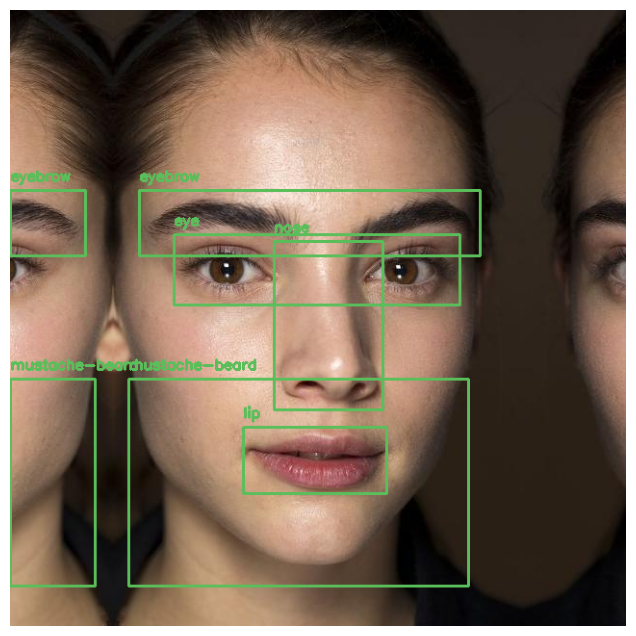

In [ ]:
def display_image_with_boxes(image_path, boxes, class_ids, class_names=None, use_matplotlib=True):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Draw bounding boxes
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box

        h, w, _ = image.shape
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)


        color = (90, 190, 90)
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)


        label = str(class_ids[i])
        if class_names:
            label = class_names[class_ids[i]]
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    if use_matplotlib:
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
    else:
        cv2.imshow("Image with Bounding Boxes", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.waitKey(0)
        cv2.destroyAllWindows()


image_path = train_path[100]
boxes = train_bbox[100]
class_ids = train_classes[100]
display_image_with_boxes(image_path, boxes, class_ids, class_names=class_mapping)

In [ ]:
train_bbox = tf.ragged.constant(train_bbox)
train_classes = tf.ragged.constant(train_classes)
train_path = tf.ragged.constant(train_path)

val_bbox = tf.ragged.constant(val_bbox)
val_classes = tf.ragged.constant(val_classes)
val_path = tf.ragged.constant(val_path)


train_dataset = tf.data.Dataset.from_tensor_slices((train_path, train_classes, train_bbox))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_path, val_classes, val_bbox))

In [ ]:
def load_img(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image


def load_dataset(img_path, classes, bbox):
    image = load_img(img_path)

    bounding_boxes = {
        "classes" : tf.cast(classes, tf.float32),
        "boxes" : bbox
    }
    return {"images" : tf.cast(image, tf.float32), "bounding_boxes" : bounding_boxes}

In [ ]:
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(height, width), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(height, width),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

In [ ]:
train_dataset = train_dataset.map(load_dataset, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(batch_size * 4)
train_dataset = train_dataset.ragged_batch(batch_size, drop_remainder = True)
train_dataset = train_dataset.map(augmenter, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
valid_dataset = valid_dataset.map(load_dataset, num_parallel_calls = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.shuffle(batch_size * 4)
valid_dataset = valid_dataset.ragged_batch(batch_size, drop_remainder = True)
valid_dataset = valid_dataset.map(resizing, num_parallel_calls = tf.data.AUTOTUNE)

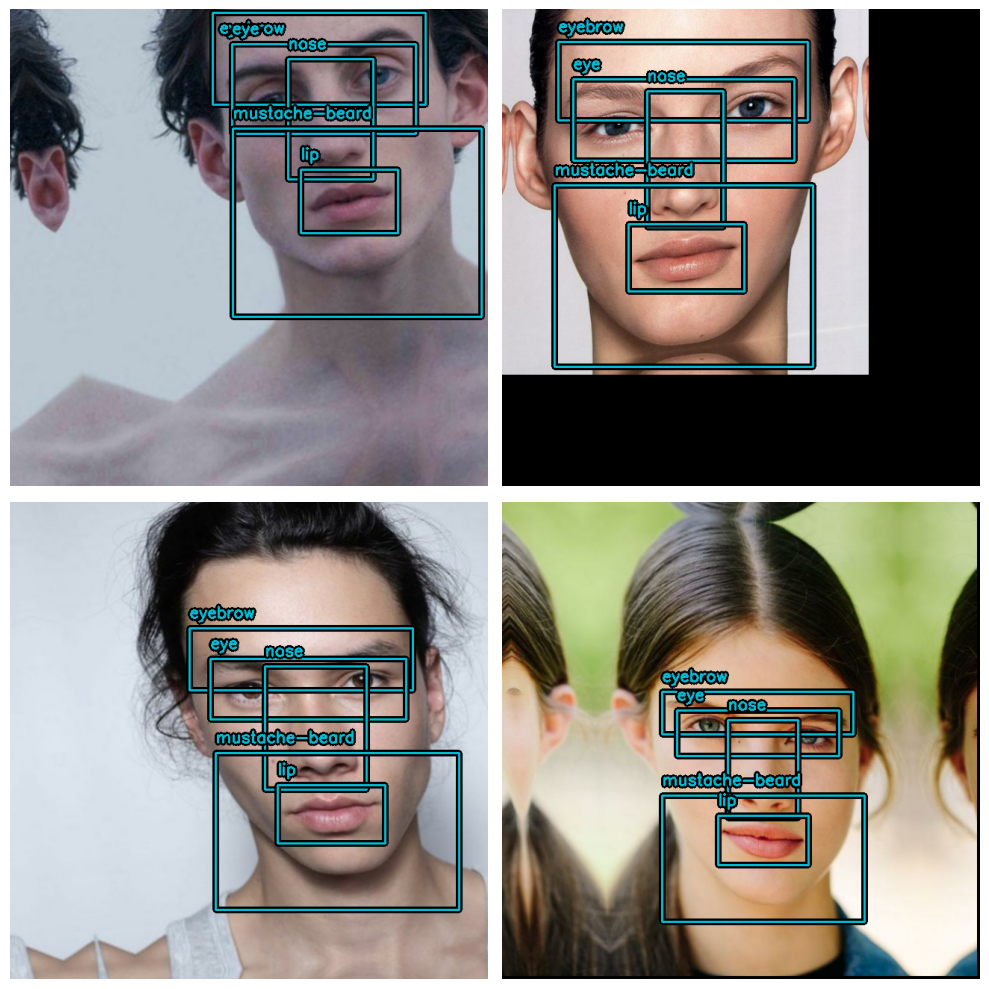

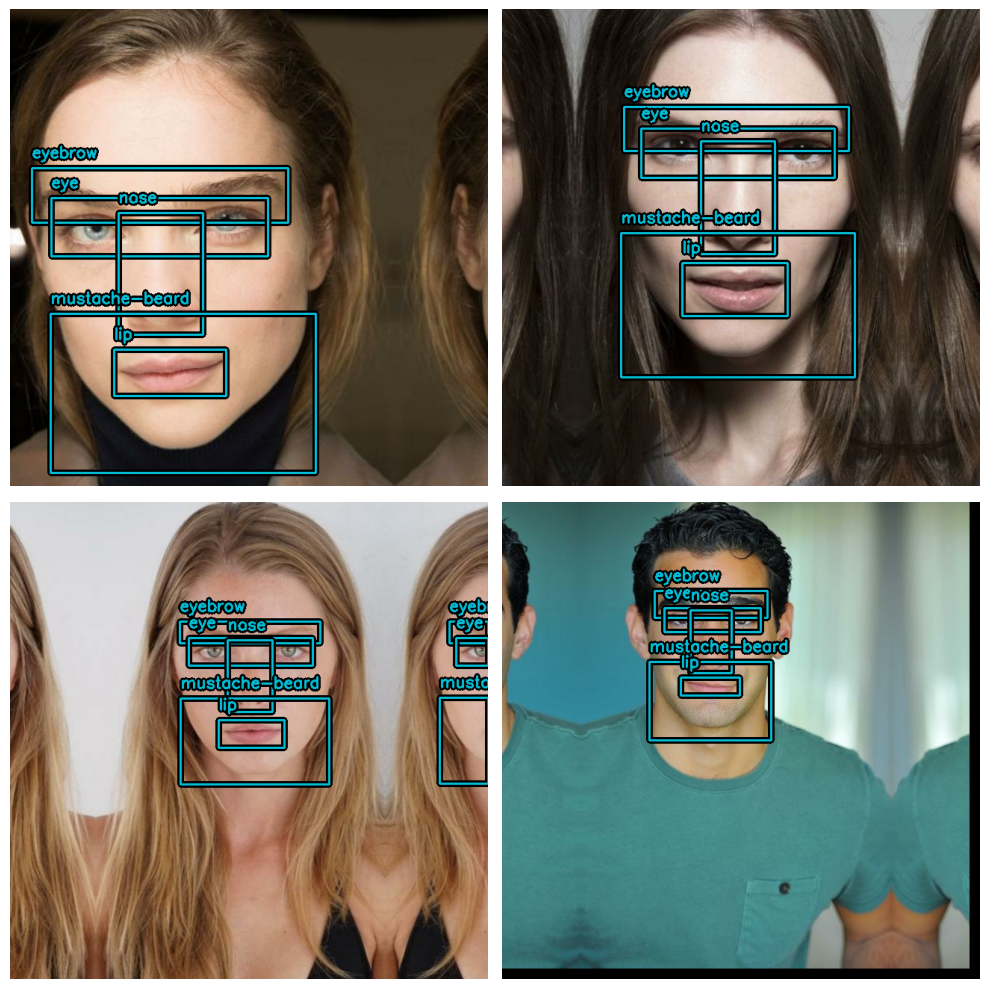

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

visualize_dataset(valid_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=5
    )
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [ ]:
backbone.summary()

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
yolo.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate = learning_rate,
    global_clipnorm = global_clipnorm,
)

yolo.compile(
    optimizer=optimizer,
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    jit_compile=False
)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [ ]:
yolo.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 10,
    callbacks = [EvaluateCOCOMetricsCallback(valid_dataset, "model.keras")],
)

In [ ]:
yolo.load_weights("/content/model.keras")

In [ ]:
yolo.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format = "xyxy",
    from_logits = True,
    iou_threshold = 0.5,
    confidence_threshold = 0.6,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


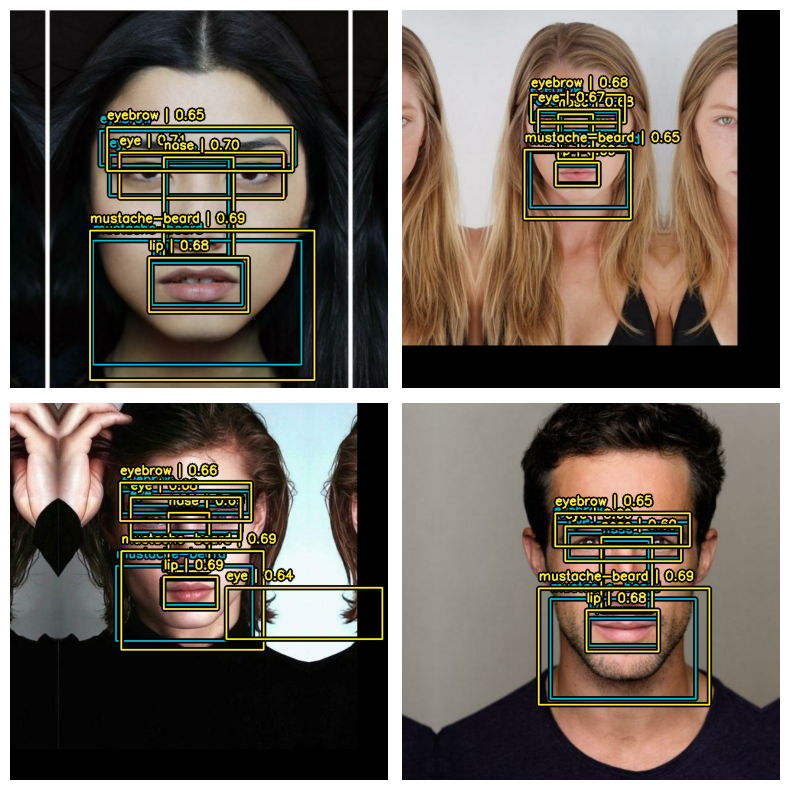

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    #y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=valid_dataset, bounding_box_format="xyxy")

In [104]:
p_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xyxy", pad_to_aspect_ratio=True
)

In [110]:
import numpy as np

def detect_and_visualize(model, image_path=None, class_mapping = class_mapping):
    """
    - Loads and preprocesses an image
    - Runs inference using YOLO
    - Applies Non-Max Suppression (NMS)
    - Visualizes the predictions with bounding boxes and class labels
    """
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = p_resizing([image])
    y_pred = model.predict(image)

    visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        bounding_box_format="xyxy",
        #y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [ ]:
image_path = "/content/20230422_132332-removebg-preview.jpg"  # Change this to your image path
detect_and_visualize(model = yolo, image_path = image_path)